# Monet GAN

## Project Summary

The goal of this project is to be able to create Monet-like paintings from the given dataset of real-world photographs using a GAN-based model.

The dataset consists of two types of images: real-world photographs and Monet paintings. Each image is of size 256x256 pixels, and there are thousands of images in the dataset, requiring effective preprocessing and transformations to ensure model compatibility.




In [31]:
import os
import torch
import random
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, SubsetRandomSampler

import warnings
warnings.simplefilter("ignore")

In [32]:
# Define base directory
GGS_PATH = r"C:\Users\sempt\Desktop\School\Masters\Intro to Deep Learning\Week 5\gan-getting-started"

# Define subdirectories for images
PATHS = {
    "photos": os.path.join(GGS_PATH, "photo_jpg"),
    "monets": os.path.join(GGS_PATH, "monet_jpg"),
}

os.chdir(GGS_PATH)

# Count files in a given directory
def count_files(path, label):
    try:
        num_files = len(os.listdir(path))
        print(f"The number of {label} is = {num_files}")
    except FileNotFoundError:
        print("Directory not found")

# Number of files
count_files(PATHS["photos"], "photos")
count_files(PATHS["monets"], "monets")

OUTPUT_PATH = "OUTPUT"
os.makedirs(OUTPUT_PATH, exist_ok = True)
weights_dir = os.path.join(OUTPUT_PATH, "weights")
os.makedirs(weights_dir, exist_ok = True)

The number of photos is = 7038
The number of monets is = 300


## EDA

The plan of analysis for this project is totrain a GAN model to learn Monet’s artistic style and use it with realistic photos to create monet-style art while minimizing mode collapse and improving image diversity.


Image shape: (256, 256, 3)


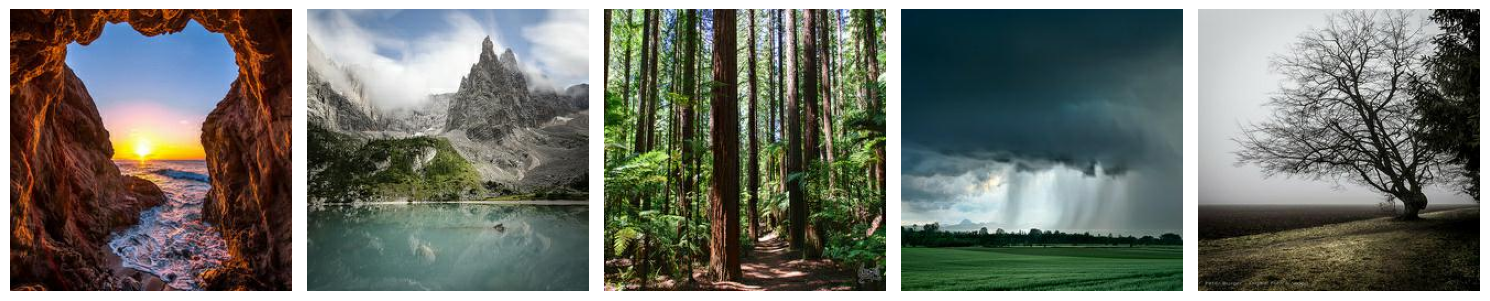

In [33]:
# Retrive list of images from given directory
def get_image_files(directory, max_images = 5):
    images = [file for file in os.listdir(directory) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
    return random.sample(images, min(max_images, len(images))) if images else []

# Display given images
def display_images(image_files, directory):
    if not image_files:
        print("No images found in directory.")
        return
    
    fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))
    if len(image_files) == 1:
        axes = [axes]  # Ensure axes is iterable when only one image is displayed
    
    for x, image_name in enumerate(image_files):
        path = os.path.join(directory, image_name)
        img = plt.imread(path)
        
        if x == 0:
            print("Image shape:", img.shape)
        
        axes[x].imshow(img)
        axes[x].axis('off')
    
    plt.tight_layout()
    plt.show()

display_images(get_image_files(PATHS["photos"]), PATHS["photos"])

## Model Architecture


The model is a GAN, which consists of a Generator and a Discriminator neural network. The Generator is responsible for creating Monet-style images from random noise, while the Discriminator evaluates the generated images and distinguishes them from real Monet paintings.

The Generator comprises multiple fully connected layers with ReLU activations and a final Tanh activation to produce normalized pixel values. The Discriminator follows a similar structure but includes a Sigmoid activation at the output to classify images as real or fake.


In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(channels, affine = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(channels, channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(channels, affine = True)
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [35]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3, bias = False),
            nn.InstanceNorm2d(64, affine = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1, bias = False),
            nn.InstanceNorm2d(128, affine = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1, bias = False),
            nn.InstanceNorm2d(256, affine = True),
            nn.ReLU(inplace = True),
            *[ResidualBlock(256) for _ in range(9)],
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.InstanceNorm2d(128, affine = True),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.InstanceNorm2d(64, affine = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 3, kernel_size = 7, stride = 1, padding = 3, bias = False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.InstanceNorm2d(128, affine = True),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.InstanceNorm2d(256, affine = True),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 512, kernel_size = 4, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(512, affine = True),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 1, bias = False)
        )

    def forward(self, x):
        return self.model(x)

In [36]:
device = torch.device("cpu")

adv_loss = nn.MSELoss()
cyc_loss = nn.L1Loss()
gen_real_to_monet = Generator().to(device)  # Real to Monet
gen_monet_to_real = Generator().to(device)  # Monet to Real
disc_real = Discriminator().to(device)      # Real discriminator
disc_monet = Discriminator().to(device)     # Monet discriminator
opt_gen = optim.Adam(list(gen_real_to_monet.parameters()) + list(gen_monet_to_real.parameters()), lr = .001, betas = (0.5, 0.999))
opt_disc_real = optim.Adam(disc_real.parameters(), lr = .001, betas = (0.5, 0.999))
opt_disc_monet = optim.Adam(disc_monet.parameters(), lr = .001, betas = (0.5, 0.999))


In [37]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform = None):
        self.directory = directory
        self.transform = transform
        self.paths = self._get_paths(directory)

    def _get_paths(self, directory):
        valid_extensions = ('.jpg', '.jpeg', '.png')
        return [os.path.join(directory, img) for img in os.listdir(directory) if img.lower().endswith(valid_extensions)]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, x):
        path = self.paths[x]
        image = self._load_image(path)

        if self.transform:
            image = self.transform(image)
        
        return image

    def _load_image(self, path):
        return Image.open(path).convert("RGB")
    
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [38]:
def create_subset_dataloader(dataset, subset, batch):
    subset_indices = _get_subset_indices(len(dataset), subset)
    sampler = SubsetRandomSampler(subset_indices)
    return _create_dataloader(dataset, batch, sampler)

# Generate random subset indices
def _get_subset_indices(samples, subset):
    subset_size = int(subset * samples)
    return np.random.choice(np.arange(samples), size = subset_size, replace = False)

# Create DataLoader with the given sampler
def _create_dataloader(dataset, batch, sampler):
    return DataLoader(dataset, batch_size = batch, sampler = sampler)

# Initialize datasets
real_images_dataset = ImageDataset(directory = PATHS["photos"], transform = transform)
monet_images_dataset = ImageDataset(directory = PATHS["monets"], transform = transform)

In [39]:
def train_discriminator(optimizer_disc_real, optimizer_disc_monet, real_images, monet_images, fake_monet, fake_real, disc_real, disc_monet, adversarial_loss, device):
    # Discriminator disc_real (Real -> Monet)
    real_labels = torch.ones(disc_real(monet_images).shape).to(device)
    fake_labels = torch.zeros(disc_real(monet_images).shape).to(device)
    
    disc_real_loss_real = adversarial_loss(disc_real(monet_images), real_labels)
    disc_real_loss_fake = adversarial_loss(disc_real(fake_monet.detach()), fake_labels)
    disc_real_loss = (disc_real_loss_real + disc_real_loss_fake) / 2
    
    optimizer_disc_real.zero_grad()
    disc_real_loss.backward()
    optimizer_disc_real.step()

    # Discriminator disc_monet (Monet -> Real)
    disc_monet_loss_real = adversarial_loss(disc_monet(real_images), real_labels)
    disc_monet_loss_fake = adversarial_loss(disc_monet(fake_real.detach()), fake_labels)
    disc_monet_loss = (disc_monet_loss_real + disc_monet_loss_fake) / 2
    
    optimizer_disc_monet.zero_grad()
    disc_monet_loss.backward()
    optimizer_disc_monet.step()

    return disc_real_loss, disc_monet_loss

def train_generator(optimizer_gen, fake_monet, fake_real, real_images, monet_images, disc_real, disc_monet, adversarial_loss, cycle_loss, device):
    # Adversarial loss for Generator
    gen_XtoY_loss = adversarial_loss(disc_real(fake_monet), torch.ones(disc_real(fake_monet).shape).to(device))
    gen_YtoX_loss = adversarial_loss(disc_monet(fake_real), torch.ones(disc_monet(fake_real).shape).to(device))

    # Cycle consistency loss
    reconstructed_real = gen_real_to_monet(fake_monet)
    reconstructed_monet = gen_real_to_monet(fake_real)
    cycle_real_loss = cycle_loss(reconstructed_real, real_images) * 10.0
    cycle_monet_loss = cycle_loss(reconstructed_monet, monet_images) * 10.0

    # Total Generator loss
    gen_loss = gen_XtoY_loss + gen_YtoX_loss + cycle_real_loss + cycle_monet_loss
    
    optimizer_gen.zero_grad()
    gen_loss.backward()
    optimizer_gen.step()

    return gen_loss, fake_monet, fake_real

def save_images_and_models(epoch, fake_monet, fake_real, monet_images, real_images, gen_real_to_monet, gen_monet_to_real, disc_real, disc_monet, OUTPUT_path, weights_dir):
    # Save example training images
    save_image(fake_monet, os.path.join(OUTPUT_path, f'fake_monet_{epoch + 1}.png'))
    save_image(fake_real, os.path.join(OUTPUT_path, f'fake_real_{epoch + 1}.png'))
    save_image(monet_images, os.path.join(OUTPUT_path, f'real_monet_{epoch + 1}.png'))
    save_image(real_images, os.path.join(OUTPUT_path, f'real_real_{epoch + 1}.png'))

    # Save model weights
    torch.save(gen_real_to_monet.state_dict(), os.path.join(weights_dir, f'gen_real_to_monet_epoch_{epoch + 1}.pth'))
    torch.save(gen_monet_to_real.state_dict(), os.path.join(weights_dir, f'gen_monet_to_real_epoch_{epoch + 1}.pth'))
    torch.save(disc_real.state_dict(), os.path.join(weights_dir, f'disc_real_epoch_{epoch + 1}.pth'))
    torch.save(disc_monet.state_dict(), os.path.join(weights_dir, f'disc_monet_epoch_{epoch + 1}.pth'))

def train_model(epochs, real_images_dataset, monet_images_dataset, subset, batch, optimizer_disc_real, optimizer_disc_monet, optimizer_gen, disc_real, disc_monet, gen_real_to_monet, gen_monet_to_real, adversarial_loss, cycle_loss, device, OUTPUT_path, weights_dir):
    for epoch in range(epochs):
        real_images_loader = create_subset_dataloader(real_images_dataset, subset, batch)
        monet_images_loader = create_subset_dataloader(monet_images_dataset, subset, batch)

        for real_images in tqdm(real_images_loader):
            for monet_images in monet_images_loader:
                real_images, monet_images = real_images.to(device), monet_images.to(device)

                # Generate fake images
                fake_monet = gen_real_to_monet(real_images)
                fake_real = gen_monet_to_real(monet_images)

                # Train Discriminator
                disc_real_loss, disc_monet_loss = train_discriminator(optimizer_disc_real, optimizer_disc_monet, real_images, monet_images, fake_monet, fake_real, disc_real, disc_monet, adversarial_loss, device)

                # Train Generator
                gen_loss, fake_monet, fake_real = train_generator(optimizer_gen, fake_monet, fake_real, real_images, monet_images, disc_real, disc_monet, adversarial_loss, cycle_loss, device)

        # Save images and model weights
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch + 1} / {epochs}] | Disc Real Loss: {disc_real_loss.item()} | Disc Monet Loss: {disc_monet_loss.item()} | Gen Loss: {gen_loss.item()}")
            save_images_and_models(epoch, fake_monet, fake_real, monet_images, real_images, gen_real_to_monet, gen_monet_to_real, disc_real, disc_monet, OUTPUT_path, weights_dir)


In [40]:
# Training parameters
epochs = 2          
subset = 0.01  
batch = 1          

# Switch components to training mode
gen_real_to_monet.train()
gen_monet_to_real.train()
disc_real.train()
disc_monet.train()

# Execute the training function
print("Starting GAN training")
train_model(
    epochs = epochs,
    real_images_dataset = real_images_dataset,
    monet_images_dataset = monet_images_dataset,
    subset = subset,
    batch = batch,
    optimizer_disc_real = opt_disc_real,
    optimizer_disc_monet = opt_disc_monet,
    optimizer_gen = opt_gen,
    disc_real = disc_real,
    disc_monet = disc_monet,
    gen_real_to_monet = gen_real_to_monet,
    gen_monet_to_real = gen_monet_to_real,
    adversarial_loss = adv_loss,
    cycle_loss = cyc_loss,
    device = device,
    OUTPUT_path = OUTPUT_PATH,
    weights_dir = weights_dir
)
print("Training complete!")

Starting GAN training


100%|██████████| 70/70 [16:41<00:00, 14.31s/it]


Epoch [1 / 2] | Disc Real Loss: 0.17404192686080933 | Disc Monet Loss: 0.1800152063369751 | Gen Loss: 6.373587131500244


100%|██████████| 70/70 [16:54<00:00, 14.50s/it]

Epoch [2 / 2] | Disc Real Loss: 0.12309819459915161 | Disc Monet Loss: 0.5755317807197571 | Gen Loss: 5.909432411193848
Training complete!


In [41]:
output_images_path = '../images'
if os.path.exists(output_images_path) == False:
    os.makedirs(output_images_path)

# Set back to evaluation mode after training
gen_real_to_monet.eval()
gen_monet_to_real.eval()
disc_real.eval()
disc_monet.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [42]:
# Create output directories
def create_output_dirs(output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output_dir_real = os.path.join(os.path.dirname(output_dir), "output_real")
    if not os.path.exists(output_dir_real):
        os.makedirs(output_dir_real)
    
    return output_dir_real

# Generate monet-style images and save them along with real images
def save_generated_images(generator, real_img, output_dir, output_dir_real, index, device):
    real_img = real_img.to(device)
    fake_monet = generator(real_img)
    
    fake_image_path = os.path.join(output_dir, f"{index}.jpg")
    save_image(fake_monet, fake_image_path)
    
    real_image_path = os.path.join(output_dir_real, f"{index}.jpg")
    save_image(real_img, real_image_path)

# Generate as save images using generator model
def predict_and_save_images(generator, input_dir, output_dir, transform, device):
    output_dir_real = create_output_dirs(output_dir)
    
    real_imgs_dataset = ImageDataset(directory = input_dir, transform = transform)
    real_imgs_loader = DataLoader(real_imgs_dataset, batch_size = 1)

    for x, real_img in enumerate(tqdm(real_imgs_loader)):
        save_generated_images(generator, real_img, output_dir, output_dir_real, x, device)

    return output_dir_real

Generating sample images


100%|██████████| 7038/7038 [39:54<00:00,  2.94it/s]

Original Images
Image shape: (256, 256, 3)


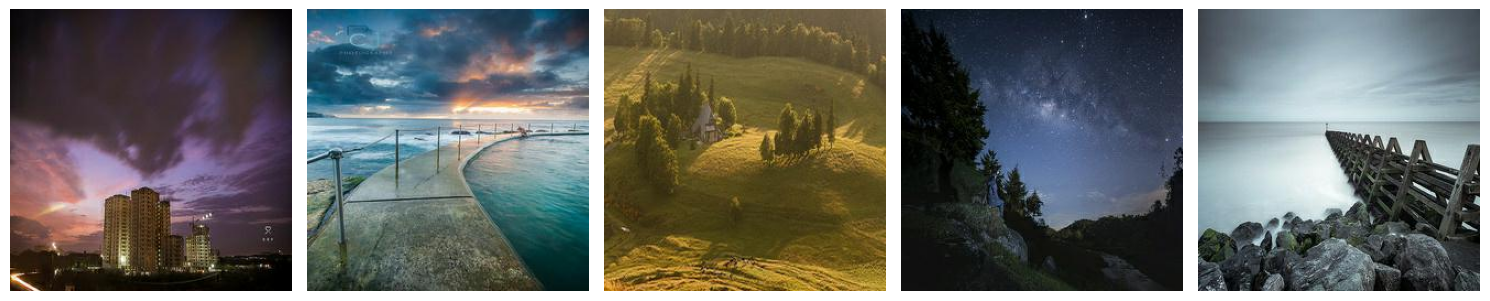

Generated Images
Image shape: (256, 256, 3)


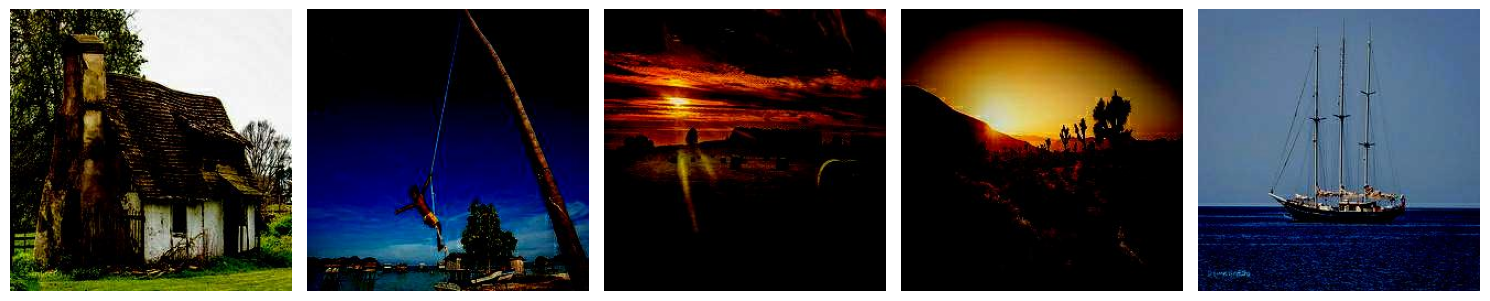

In [44]:
# Save the generated images and display them
print("Generating sample images")
output_dir_real = predict_and_save_images(gen_real_to_monet, PATHS["photos"], output_images_path, transform, device)

print("Original Images")
display_images(get_image_files(PATHS["photos"]), PATHS["photos"])

print("Generated Images")
display_images(get_image_files(output_dir_real), output_dir_real)

## Analysis

As you can see from the generated images above, they are for the most part monet-style images. Some of the images look pretty good, while others are extremely saturated or blurry. However, most images you are able to make out what it is.

## Conclusion

A GAN model was trained to generate Monet-style paintings from photographs. The model demonstrated decent results, with generated images resembling real Monet artworks. However, challenges such as training instability, mode collapse, and overfitting were observed during the process.

In order to improve performance, increasing dataset size, fine-tuning hyperparameters and experimenting with different architectures could help with increasing the quality of generated images.
